In [1]:
!pip install torch-snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 23.4 MB/s eta 0:0

In [2]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
import os, os.path as osp


[07/02/23 21:08:20] WARNING  Unable to load torch and dependent libraries from                ]8;id=110150;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py\loader.py]8;;\:]8;id=380384;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py#<module>:98\<module>:98]8;;\
                             torch-snippets.                                                                       
                             Functionalities might be limited. pip install lovely-tensors in                       
                             case there are torch related errors                                                   

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/Shareddrives/MO434/dataset/project_dataset_corel.zip .
!unzip -q project_dataset_corel.zip

### Hyperparameters

In [5]:
batchsize = 32
n_class = 6
n_fold = 3
input_shape = (3,224,224)
device = torch.device('cuda')
test_only = False
fine_tune = True

lr = 1e-3
weight_decay=1e-4
n_epochs = 100

model_name = 'CMKNet'

scheduler_step=20
scheduler_gamma = 0.5

dataset_dir = "/content/project_dataset_corel"

log_dir='/content/drive/Shareddrives/MO434/executions/dnn/resnet18_fine'

def create_dir_if_necessary(dir):
    try:
        os.makedirs(dir)
    except FileExistsError:
        pass
create_dir_if_necessary(log_dir)

### Define dataset

Training, validation

In [6]:
import cv2
from PIL import Image
import os, os.path as osp

def list_join_dir(dir):
    return sorted([osp.join(dir, f) for f in os.listdir(dir)])

class DataSet():
    def __init__(self, set_dir, class_red_circle=None, transforms=None) -> None:
        self.set_dir = set_dir
        self.transforms = transforms
        self.class_red_circle = class_red_circle

        self.img_dir = set_dir

        red_circle_dir = osp.join(osp.dirname(osp.dirname(osp.abspath(self.set_dir))), 'red_circle')
        if self.class_red_circle is not None:
            red_circle_img = cv2.imread(osp.join(red_circle_dir, 'red_circle.png'), cv2.IMREAD_COLOR)
            mask = cv2.imread(osp.join(red_circle_dir, 'circle_mask.png'), cv2.IMREAD_GRAYSCALE)

        self.images, self.gts = [], []
        for img_path in list_join_dir(self.img_dir):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img_basename = osp.basename(img_path)
            class_id = int(img_basename.split('.')[0].split('_')[0])

            if self.class_red_circle is not None and self.class_red_circle == class_id:
                img = cv2.bitwise_and(img, img, mask=mask)
                img += red_circle_img

            self.images.append(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
            self.gts.append(class_id)
            cv2.imwrite

    def __getitem__(self, idx):
        if self.transforms:
            return self.transforms(self.images[idx]), self.gts[idx]
        return self.images[idx], self.gts[idx]

    def __len__(self):
        return len(self.images)


### Define transforms

In [7]:
from torchvision import transforms

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            fill=0),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #AddGaussianNoise(0, 0.1)
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

### Define CNN architecture

In [8]:
import torch
from torch import nn as nn
import math
import torchvision

def ResNet18():
    model = torchvision.models.resnet18(weights='DEFAULT' if fine_tune else None)
    if fine_tune:
        for param in model.parameters():
            param.requires_grad = False
    old_conv = model.fc
    model.fc = nn.Linear(old_conv.in_features, n_class, bias=True)
    nn.init.xavier_uniform(model.fc.weight)
    model.fc.bias.data.zero_()
    return model

def get_model(params_dir=None):
    model = ResNet18()
    if params_dir:
        model.load_state_dict(torch.load(params_dir, map_location=device))
    return model


### Train Folds

In [9]:
from torch.utils.data import DataLoader
from torchsummary import summary


def train_batch(model, data, optimizer, criterion, device):
    optimizer.zero_grad()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss = criterion(preds, targets)
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def validate(model, loader, criterion, device):
    #loader batchsize should be 1 for validation
    model.eval()
    rights = 0
    errors = 0
    cnt = len(loader)
    loss = 0
    for _, data in enumerate(loader):
        img, label = data
        img = img.to(device)
        label = label.to(device)
        pred = model(img)
        if torch.argmax(pred).item() == label.item():
            rights += 1
        else:
            errors += 1
        loss += criterion(pred, label)
    return loss/cnt, rights/cnt # average loss and accuracy

def train(dataset_dir, log_dir, best_model_path):
    # DataLoaders
    train_set = DataSet(osp.join(dataset_dir, 'train'), transforms=train_transforms)
    val_set = DataSet(osp.join(dataset_dir, 'val'), transforms=val_transforms)

    train_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

    # Define Model
    model = get_model().to(device)
    summary(model,input_shape)

    # Optimizer, scheduler and loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

    log      = Report(n_epochs)
    model.train()

    best_model = None
    best_model_loss = sys.maxsize

    for epoch in range(n_epochs):
        N = len(train_loader)
        epoch_train_loss = 0
        for bx, data in enumerate(train_loader):
            loss = train_batch(model, data, optimizer, criterion, device)
            epoch_train_loss += loss

        loss, acc = validate(model, val_loader, criterion, device)
        if loss < best_model_loss:
            torch.save(model.state_dict(), best_model_path)
            best_model_loss = loss
            best_model = epoch

        log.record(epoch+1, train_loss=epoch_train_loss/N, val_loss=loss, val_acc=acc,
                best_model=best_model+1, best_loss=best_model_loss, end='\r')

        lr_scheduler.step()

    log.plot_epochs(['train_loss','val_loss'])
    log.plot_epochs(['val_acc'])

In [10]:
from sklearn import metrics
import numpy as np
import torch
import pandas as pd

@torch.no_grad()
def test_fold(model, loader, criterion, device):
    #loader batchsize should be 1 for validation
    model.eval()
    preds, gts = [], []
    cnt = len(loader)
    loss = 0
    for _, data in enumerate(loader):
        img, label = data
        img = img.to(device)
        label = label.to(device)
        pred = model(img)
        preds.append(torch.argmax(pred).item())
        gts.append(label.item())
        loss += criterion(pred, label)
    return loss/cnt, preds, gts

def calculate_metrics(preds, gts):
    preds, gts = np.array(preds), np.array(gts)
    gen_acc = metrics.accuracy_score(gts, preds)
    gen_cohen_kappa = metrics.cohen_kappa_score(preds, gts)

    acc_per_class = []
    cohen_per_class = []

    n_class = gts.max() + 1

    for class_id in range(n_class):
        cohen_score = metrics.cohen_kappa_score(preds==class_id, gts==class_id)
        cohen_per_class.append(cohen_score)
        acc_score = metrics.accuracy_score(preds==class_id, gts==class_id)
        acc_per_class.append(acc_score)

    per_class_results = pd.DataFrame({
        'class': list(range(n_class)),
        'acc': acc_per_class,
        'cohen_kappa': cohen_per_class
    })
    return gen_acc, gen_cohen_kappa, per_class_results

def test(dataset_dir, log_dir, best_model_path):
    test_set = DataSet(osp.join(dataset_dir, 'test'), transforms=val_transforms)
    test_loader  = DataLoader(test_set, batch_size=1, shuffle=False)

    model = get_model(params_dir=best_model_path)
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    loss, preds, gts = test_fold(model, test_loader, criterion, device)
    gen_acc, gen_cohen_kappa, per_class_r = calculate_metrics(preds, gts)

    result = f'Results \nAcc: {gen_acc:.4f}. cohen kappa: {gen_cohen_kappa:.4f}. Loss: {loss:.6f}'
    print(result)

    per_class_r.to_csv(osp.join(log_dir, 'per_class_result.csv'), index=False)

    with open(osp.join(log_dir, 'results.txt'), 'w') as f:
        f.write(result)

    return gen_acc, gen_cohen_kappa, per_class_r


### Train Test Folds

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 278MB/s]
<ipython-input-8-cf9170dcb64e>:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(model.fc.weight)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

100%|██████████| 201/201 [00:00<00:00, 18564.59it/s]


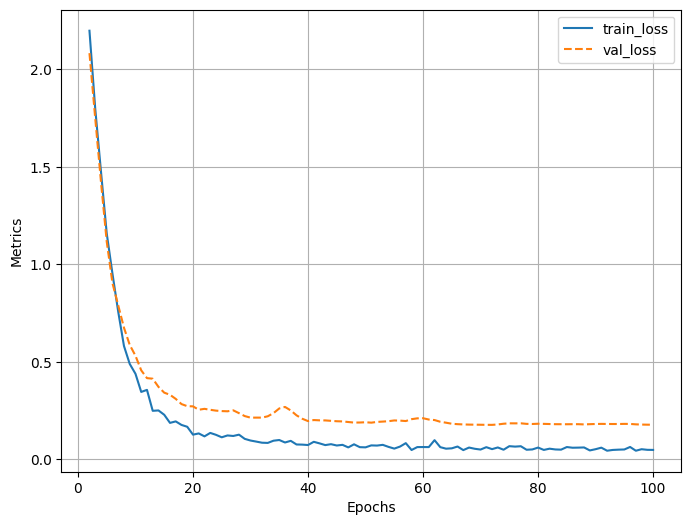

100%|██████████| 201/201 [00:00<00:00, 33153.29it/s]


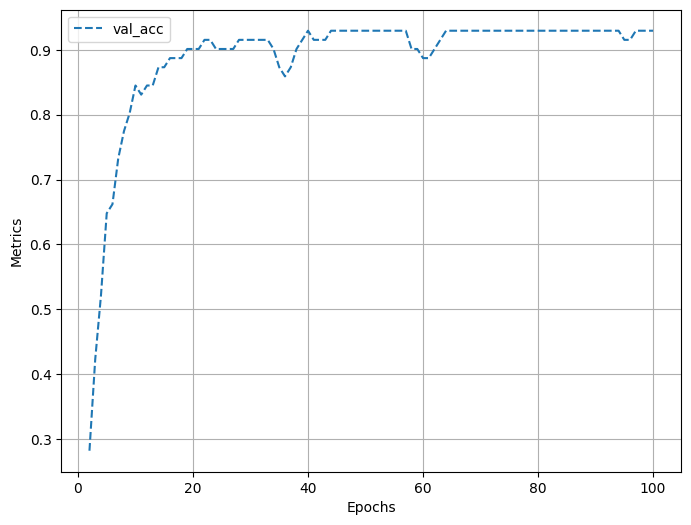

Results 
Acc: 0.9664. cohen kappa: 0.9585. Loss: 0.110399

<ipython-input-8-cf9170dcb64e>:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(model.fc.weight)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

100%|██████████| 201/201 [00:00<00:00, 17547.56it/s]


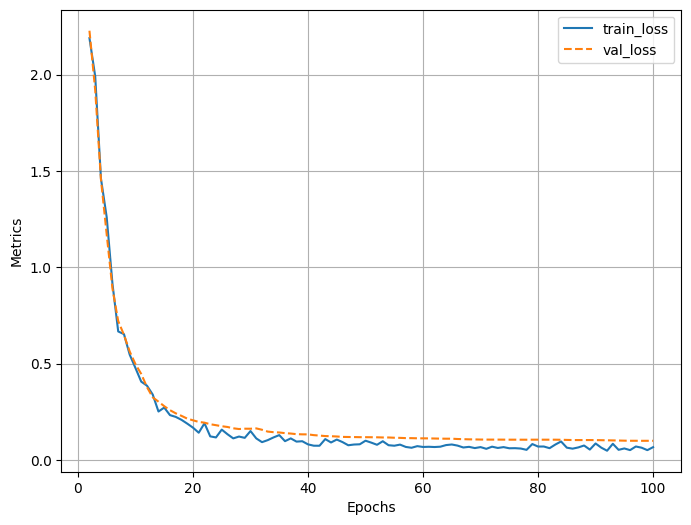

100%|██████████| 201/201 [00:00<00:00, 31332.19it/s]


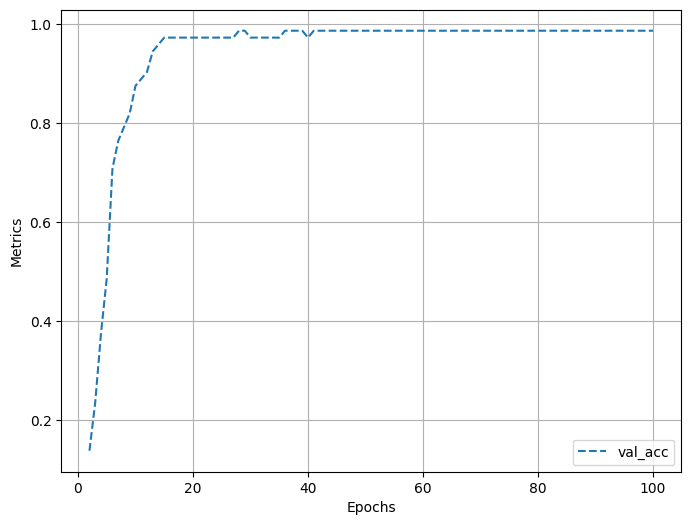

Results 
Acc: 0.9576. cohen kappa: 0.9477. Loss: 0.132826

<ipython-input-8-cf9170dcb64e>:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(model.fc.weight)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

100%|██████████| 201/201 [00:00<00:00, 17659.67it/s]


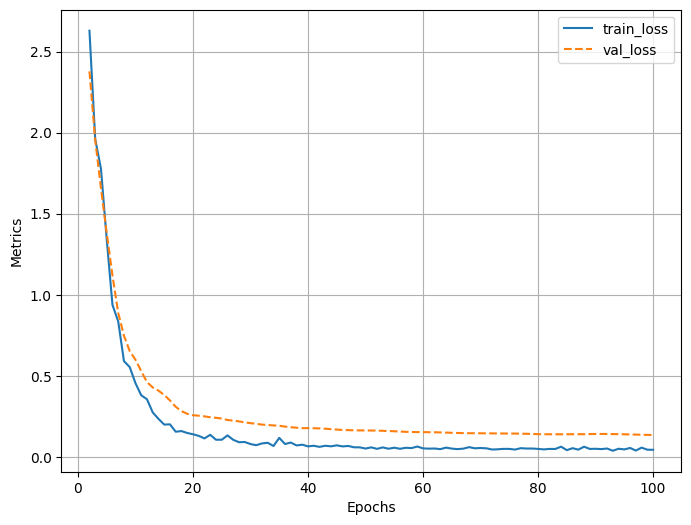

100%|██████████| 201/201 [00:00<00:00, 26301.91it/s]


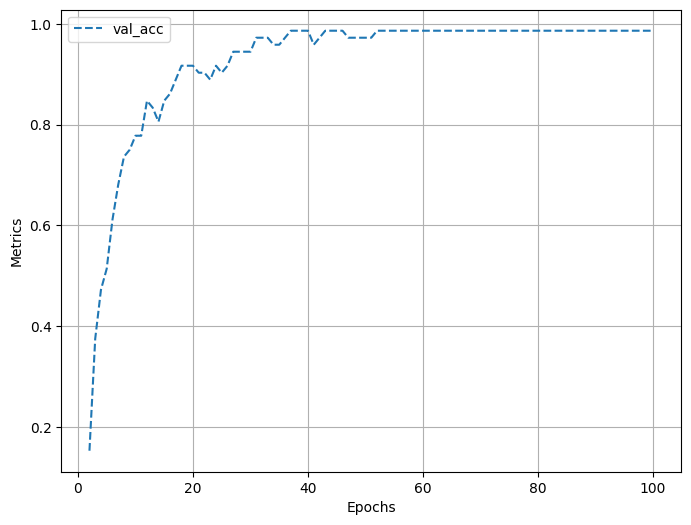

Results 
Acc: 0.9237. cohen kappa: 0.9053. Loss: 0.197399

In [11]:
all_acc, all_cohen_kappa, all_per_class_r = [], [], pd.DataFrame()

for fold in range(n_fold):
    fold_dir = osp.join(dataset_dir, f'fold{fold}')
    fold_log_dir = osp.join(log_dir, f'fold{fold}')
    create_dir_if_necessary(fold_log_dir)

    best_model_path = osp.join(fold_log_dir, 'best_model.pth')

    if not test_only:
        train(fold_dir, fold_log_dir, best_model_path)
    gen_acc, gen_cohen_kappa, per_class_r = test(fold_dir, fold_log_dir, best_model_path)

    all_acc.append(gen_acc)
    all_cohen_kappa.append(gen_cohen_kappa)
    all_per_class_r = pd.concat((all_per_class_r, per_class_r), ignore_index=True)

In [12]:
# 'class', 'acc', 'cohen_kappa'
all_per_class_r = all_per_class_r.groupby(by='class').agg(
    class_id=('class', 'last'),
    mean_acc=('acc', 'mean'),
    std_acc=('acc','std'),
    mean_kappa=('cohen_kappa', 'mean'),
    std_kappa=('cohen_kappa','std')
).reset_index(drop=True)

all_per_class_r.to_csv(osp.join(log_dir, 'per_class_result.csv'), index=False)

result = f"""Mean acc: f{np.mean(all_acc):.4f}. Std acc: f{np.std(all_acc):.4f}
Mean kappa: f{np.mean(all_cohen_kappa):.4f}. Std kappa: f{np.std(all_cohen_kappa):.4f}
"""
with open(osp.join(log_dir, 'results.txt'), 'w') as f:
    f.write(result)
print(result)

Mean acc: f0.9492. Std acc: f0.0184
Mean kappa: f0.9372. Std kappa: f0.0230